# EECS16A: Homework 4

## Problem 7: Segway Tours

Run the following block of code first to get all the dependencies.

In [1]:
# %load gauss_elim.py
from gauss_elim import gauss_elim

from numpy import zeros, cos, sin, arange, around, hstack
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
import numpy as np
from scipy.interpolate import interp1d
import scipy as sp

## Example Usage of gauss_elim

In [2]:
def test_gauss_elim(A, b):
    aug_matrix = np.c_[A, b]
    print('Augmented:')
    print(aug_matrix)
    print('\nAfter GE:')
    print(gauss_elim(aug_matrix) )

test_gauss_elim(np.array([[3, 10], \
                          [-2, 5]]), \
                np.array([35, 0]) \
               )

Augmented:
[[ 3 10 35]
 [-2  5  0]]

After GE:
[[1 0 5]
 [0 1 2]]


## Dynamics

In [3]:
# Dynamics: state to state
A = np.array([[1, 0.05, -.01, 0],
              [0, 0.22, -.17, -.01],
              [0, 0.1, 1.14, 0.10],
              [0, 1.66, 2.85, 1.14]]);
# Control to state
b = np.array([.01, .21, -.03, -0.44])
nr_states = b.shape[0]

# Initial state
state0 = np.array([-0.3853493, 6.1032227, 0.8120005, -14])

# Final (terminal state)
stateFinal = np.array([0, 0, 0, 0])

## Part (d)

In [4]:
# YOUR CODE HERE!
test_gauss_elim(np.column_stack(((A @ b), b)), -np.matmul(A, A) @ state0)
# Complete Gaussian Elimination to see if we can reach stateFinal in 2 steps.

Augmented:
[[ 0.0208      0.01        0.02243475]
 [ 0.0557      0.21       -0.30785117]
 [-0.0572     -0.03        0.06193476]
 [-0.2385     -0.44        1.38671326]]

After GE:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]
 [ 0.  0.  0.]]


## Part (e)

In [5]:
test_gauss_elim(np.column_stack((np.matmul(A, A) @ b, (A @ b), b)), -np.matmul(A, A, A) @ state0)
# Complete Gaussian Elimination to see if we can reach stateFinal in 3 steps.

Augmented:
[[ 0.024157    0.0208      0.01        0.02243475]
 [ 0.024363    0.0557      0.21       -0.30785117]
 [-0.083488   -0.0572     -0.03        0.06193476]
 [-0.342448   -0.2385     -0.44        1.38671326]]

After GE:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [-0. -0. -0.  1.]]


## Part (f)

In [6]:
test_gauss_elim(np.column_stack((np.linalg.matrix_power(A, 3)  @ b, np.linalg.matrix_power(A, 2) @ b, (A @ b), b)), -np.linalg.matrix_power(A, 4) @ state0)
# Complete Gaussian Elimination to see if we can reach stateFinal in 4  steps.

Augmented:
[[ 3.80884492e-02  2.86287432e-02  2.41570000e-02  1.00000000e-02
  -5.75871384e-02]
 [ 8.31620516e-02  3.25213148e-02  2.43630000e-02  2.10000000e-01
  -3.72649272e-01]
 [-5.31292535e-01 -2.01253859e-01 -8.34880000e-02 -3.00000000e-02
   2.39019909e+00]
 [-2.72679089e+00 -9.93957811e-01 -3.42448000e-01 -4.40000000e-01
   1.23691837e+01]]

After GE:
[[ 1.          0.          0.          0.         -8.91571869]
 [ 0.          1.          0.          0.         13.41846556]
 [ 0.          0.          1.          0.         -4.30218205]
 [ 0.          0.          0.          1.          0.17727669]]


## Part (g)

### Preamble
This function will take care of animating the segway

In [7]:
# frames per second in simulation
fps = 20
# length of the segway arm/stick
stick_length = 1.

def animate_segway(t, states, controls, length):
    #Animates the segway
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some config
    segway_width = 0.4
    segway_height = 0.2
    
    # x coordinate of the segway stick
    segwayStick_x = length * np.add(states[:, 0],sin(states[:, 2]))
    segwayStick_y = length * cos(states[:, 2])
    
    # set the limits
    xmin = min(around(states[:, 0].min() - segway_width / 2.0, 1), around(segwayStick_x.min(), 1))
    xmax = max(around(states[:, 0].max() + segway_height / 2.0, 1), around(segwayStick_y.max(), 1))
    
    # create the axes
    ax = plt.axes(xlim=(xmin-.2, xmax+.2), ylim=(-length-.1, length+.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.05, 0.9, 'time', transform=ax.transAxes)
    
    # display the current control
    control_text = ax.text(0.05, 0.8, 'control', transform=ax.transAxes)
    
    # create rectangle for the segway
    rect = Rectangle([states[0, 0] - segway_width / 2.0, -segway_height / 2],
        segway_width, segway_height, fill=True, color='gold', ec='blue')
    ax.add_patch(rect)
    
    # blank line for the stick with o for the ends
    stick_line, = ax.plot([], [], lw=2, marker='o', markersize=6, color='blue')

    # vector for the control (force)
    force_vec = ax.quiver([],[],[],[],angles='xy',scale_units='xy',scale=1)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        control_text.set_text('')
        rect.set_xy((0.0, 0.0))
        stick_line.set_data([], [])
        return time_text, rect, stick_line, control_text

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        control_text.set_text('force = {:2.3f}'.format(controls[i]))
        rect.set_xy((states[i, 0] - segway_width / 2.0, -segway_height / 2))
        stick_line.set_data([states[i, 0], segwayStick_x[i]], [0, segwayStick_y[i]])
        return time_text, rect, stick_line, control_text

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=1000/fps, blit=False, repeat=False)
    return anim
    #plt.show()

### Plug in your controller

In [8]:
# YOUR CODE HERE!  
# controls should be a numpy array of shape (4,) if stateFinal can be reached in 4 time steps (as found in part f). 
controls = np.array([-8.91571869,13.41846556,-4.30218205,0.17727669])

### Simulation

In [9]:
# This will add an extra couple of seconds to the simulation after the input controls with no control
# the effect of this is just to show how the system will continue after the controller "stops controlling"
controls = np.append(controls,[0, 0])

# number of steps in the simulation
nr_steps = controls.shape[0]

# We now compute finer dynamics and control vectors for smoother visualization
Afine = sp.linalg.fractional_matrix_power(A,(1/fps))
Asum = np.eye(nr_states)
for i in range(1, fps):
    Asum = Asum + np.linalg.matrix_power(Afine,i)
    
bfine = np.linalg.inv(Asum).dot(b)

# We also expand the controls in the "intermediate steps" (only for visualization)
controls_final = np.outer(controls, np.ones(fps)).flatten()
controls_final = np.append(controls_final, [0])

# We compute all the states starting from x0 and using the controls
states = np.empty([fps*(nr_steps)+1, nr_states])
states[0,:] = state0;
for stepId in range(1,fps*(nr_steps)+1):
    states[stepId, :] = np.dot(Afine,states[stepId-1, :]) + controls_final[stepId-1] * bfine
    
# Now create the time vector for simulation
t = np.linspace(1/fps,nr_steps,fps*(nr_steps),endpoint=True)
t = np.append([0], t)

### Visualization

<IPython.core.display.Javascript object>


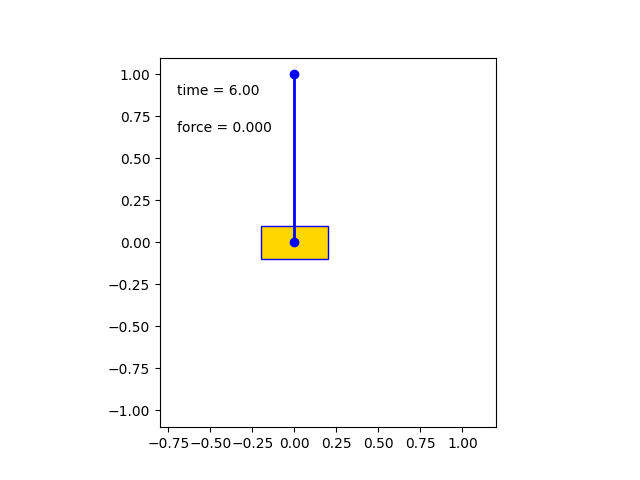

In [10]:
%matplotlib nbagg
# %matplotlib qt
anim = animate_segway(t, states, controls_final, stick_length)
anim